# Veritas Fairness Assement - Credit Scoring Case Study (sample code)
This notebook includes samples of code used in the analysis conducted during the credit scoring case study.

It is applicable to a variety of publically available credit scoring datasets.
Here it is run on the 
[Kaggle hosted UCI credit card dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset) [1,2]. 

1. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. 
Irvine, CA: University of California, School of Information and Computer Science.

2. Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480. 



## License
Written by Marc-Etienne Brunet,
Element AI inc. (info@elementai.com).

Copyright © 2020 Monetary Authority of Singapore

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

## Imports

In [2]:
# Core Packages
import os
import json

# Third Party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.calibration import calibration_curve
from sklearn import metrics

In [3]:
from bedrock_client.bedrock.analyzer.model_analyzer import ModelAnalyzer
from bedrock_client.bedrock.analyzer import ModelTypes
from bedrock_client.bedrock.api import BedrockApi
from bedrock_client.bedrock.metrics.service import ModelMonitoringService

from sklearn import metrics

pip install 'aif360[AdversarialDebiasing]'


In [107]:
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


In [8]:
from sklearn.preprocessing import OneHotEncoder

In [9]:
# Our code (autoreload)
%load_ext autoreload
%autoreload 2
import utils.credit as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# High-res plots
%config InlineBackend.figure_format = 'retina'

## AIDA System Objective

The objective of a credit approval system is to provide loans in a way that is advantageous for both the customer and for the bank.
A “good” loan is one that gets repaid. It generates revenue for the bank. A “bad” loan is one ending in default, it incurs costs for the bank. Typically, the cost from a bad loan is much higher than the revenue from a good loan.
Without some kind of lift from a predictive model, pricing must be set using the expected base default rate. 
To be more competitive, profitable, and to manage risk, banks use credit scoring models to estimate an applicant’s creditworthiness (or risk of default). 


In [11]:
def gross_profit_rate(approval_rate, default_rate, revenue=10, cost=100):
    return approval_rate * (revenue * (1 - default_rate) - cost * default_rate)

approval_rates = np.linspace(0, 1, 100)
default_rates = np.linspace(0, 0.2, 100)
grid_approval, grid_defaults = np.meshgrid(approval_rates, default_rates, sparse=True)
profit_grid = gross_profit_rate(grid_approval, grid_defaults)

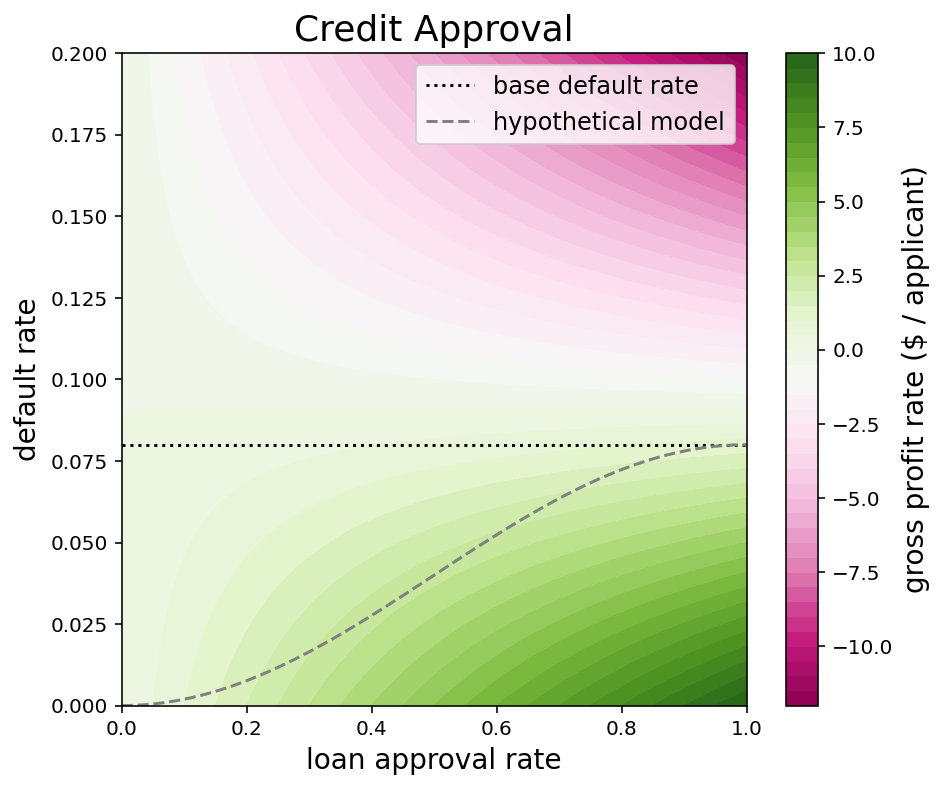

In [12]:
# Visualize
plt.figure(figsize=(7, 6))
profit_lns = plt.contourf(approval_rates, default_rates, profit_grid, cmap='PiYG', levels=50)
plt.title('Credit Approval', fontsize=18)
plt.xlabel('loan approval rate', fontsize=14)
plt.ylabel('default rate', fontsize=14)
plt.axhline(0.08, c='black', ls=':', label='base default rate')
x_eg = np.linspace(0, 1, 100)
y_eg = 0.04 * np.sin(np.pi *(x_eg - 0.5)) + 0.04
plt.plot(x_eg, y_eg, label='hypothetical model', ls='--', c='grey')
cbar = plt.colorbar(profit_lns)
cbar.set_label('gross profit rate ($ / applicant)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

For simplicity, we will use balanced accuracy (the average of true positive and true negative rates) as a proxy for gross profit. 
We show why a (possibly weighted) balanced accuracy is a reasonable proxy for gross profit in the report. 

## Load Data

In [13]:
# Extraneous columns (as might be determined through feature selection)
drop_cols = ['ID']

# Load into Dataframes
X_train, y_train = utils.load_dataset(os.path.join('data', 'creditdata', 'creditdata_train_v2.csv'), drop_columns=drop_cols)
X_test, y_test = utils.load_dataset(os.path.join('data', 'creditdata', 'creditdata_test_v2.csv'), drop_columns=drop_cols)

In [14]:
# Base default rates
print(f"Number of features: {len(X_train.columns)}")
print(f"Train set length: {len(y_train)}, default rate: {round(1 - np.mean(y_train), 4)}")
print(f"Test set length: {len(y_test)}, default rate: {round(1 - np.mean(y_test), 4)}")
print(X_train.columns)

Number of features: 23
Train set length: 22500, default rate: 0.2212
Test set length: 7500, default rate: 0.2212
Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')


## Train Model

In [78]:
# Use best parameters from a model selection and threshold tuning process
best_regularizer = 1e-1
best_th = 0.43
model = utils.train_log_reg_model(X_train, y_train, seed=0, C=best_regularizer, upsample=True, verbose=True)

upsampling...
scaling...
fitting...
C: 0.1
chaining pipeline...
done.


In [108]:
def train_rf_model(X, y, seed=0, n_estimators=100, verbose=False, upsample=True):
    if upsample:
        verbose and print('upsampling...')
        categorical_features = [i for i, col in enumerate(X.columns) if X[col].dtype == 'int8']
        smote = SMOTENC(random_state=seed, categorical_features=categorical_features)
        X, y = smote.fit_resample(X, y)

    verbose and print('scaling...')
    scaling = StandardScaler()
    X = scaling.fit_transform(X)

    verbose and print('fitting...')
    verbose and print('n_estimators:', n_estimators)
    model = RandomForestClassifier(random_state=seed, n_estimators=n_estimators)
    model.fit(X, y)

    verbose and print('chaining pipeline...')
    pipe = Pipeline([('scaling', scaling), ('model', model)])
    verbose and print('done.')
    return pipe

In [109]:
model = train_rf_model(X_train, y_train, seed=0, upsample=True, verbose=True)

upsampling...
scaling...
fitting...
n_estimators: 100
chaining pipeline...
done.


# Pycaret

In [16]:
from sklearn_pandas import DataFrameMapper
from sklearn import preprocessing


In [17]:
print(X_train.shape, type(X_train))
print(y_train.shape, type(y_train))

(22500, 23) <class 'pandas.core.frame.DataFrame'>
(22500,) <class 'numpy.ndarray'>


In [45]:
from sklearn.compose import ColumnTransformer

'''
'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
'''

categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE',
    'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
]

continuous_features = [
    'LIMIT_BAL', 'AGE',
    'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]


# # Prepare column transformers
# continuous_transformer = Pipeline(steps=[
#     ('stdscaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# col_transformer = ColumnTransformer(
#     transformers=[
#         ('cont', continuous_transformer, continuous_features),
#         ('cate', categorical_transformer, categorical_features)
#     ]
# )


In [46]:
X_train_transformed = col_transformer.fit_transform(X_train)

In [48]:
# col_transformer.named_transformers_['cont'].named_steps['stdscaler'].get_feature_names()
col_transformer.named_transformers_['cate'].named_steps['onehot'].get_feature_names()


array(['x0_1', 'x0_2', 'x1_0', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x1_5',
       'x1_6', 'x2_0', 'x2_1', 'x2_2', 'x2_3', 'x3_-2', 'x3_-1', 'x3_0',
       'x3_1', 'x3_2', 'x3_3', 'x3_4', 'x3_5', 'x3_6', 'x3_7', 'x3_8',
       'x4_-2', 'x4_-1', 'x4_0', 'x4_1', 'x4_2', 'x4_3', 'x4_4', 'x4_5',
       'x4_6', 'x4_7', 'x5_-2', 'x5_-1', 'x5_0', 'x5_1', 'x5_2', 'x5_3',
       'x5_4', 'x5_5', 'x5_6', 'x5_7', 'x5_8', 'x6_-2', 'x6_-1', 'x6_0',
       'x6_1', 'x6_2', 'x6_3', 'x6_4', 'x6_5', 'x6_6', 'x6_7', 'x6_8',
       'x7_-2', 'x7_-1', 'x7_0', 'x7_2', 'x7_3', 'x7_4', 'x7_5', 'x7_6',
       'x7_7', 'x7_8', 'x8_-2', 'x8_-1', 'x8_0', 'x8_2', 'x8_3', 'x8_4',
       'x8_5', 'x8_6', 'x8_7', 'x8_8'], dtype=object)

In [44]:
pd.DataFrame.sparse.from_spmatrix(X_train_transformed)

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-0.907510,-0.809370,-0.380751,-0.347650,-0.310103,-0.268105,-0.224725,-0.189587,-0.253106,-0.182494,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.322710,0.928294,-0.200178,-0.121293,-0.060734,-0.007274,0.073895,0.134340,-0.067378,-0.121797,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.676844,-0.700766,-0.665348,-0.683699,-0.647392,-0.658195,-0.646138,-0.575531,-0.323015,-0.167441,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.061288,0.819690,-0.382683,-0.458014,-0.453060,-0.432633,-0.402803,-0.399882,-0.254269,-0.186541,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.245821,-0.809370,-0.694728,-0.688711,-0.674167,-0.669705,-0.658293,-0.649006,-0.344930,-0.243191,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22495,4.474703,0.819690,0.284524,0.705939,0.393322,0.313836,0.727791,0.732936,5.756076,2.777111,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22496,1.476041,0.059462,-0.694728,-0.688711,-0.674167,-0.669705,-0.658293,-0.649006,-0.344930,-0.243191,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22497,-0.907510,1.145502,-0.355424,-0.321136,-0.285145,-0.379498,-0.357066,-0.335541,-0.249494,-0.182494,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22498,-0.215511,-0.157746,0.718882,0.783408,0.816285,0.878158,1.015756,1.069021,-0.038851,-0.097518,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
def get_indices_of_columns(df, column_list):
    return [i for i, col in enumerate(df.columns) if col in set(column_list)]


In [36]:
def convert_ndarray_to_df(x, x_columns):
    df = pd.DataFrame(data=x, # values
                      index=None, 
                      columns=x_columns)    
    return df

def upsample_data_with_smotenc(df_x, ndarray_y, categorical_features, continuous_features, seed=123, verbose=False):
    '''Returns an upsampled pandas dataframe of x and an ndarray of labels y
    Args:
        df_x: pandas dataframe of only features
        ndarray_y: ndarray of labels
    Return:
        df_x_upsampled (pandas dataframe)
        y (ndarray)
    '''
    print("Before: value counts for y")
    df = df_x.copy()
    df["y"] = ndarray_y
    print(df['y'].value_counts())
    
    categorical_cols_indices = get_indices_of_columns(X_train, categorical_features)
    continuous_cols_indices = get_indices_of_columns(X_train, continuous_features)
    
    # Run SMOTENC
    smote = SMOTENC(random_state=seed, categorical_features=categorical_cols_indices)
    X, y = smote.fit_resample(df_x, ndarray_y)
    
    # Convert back to df and return
    df_x_upsampled = convert_ndarray_to_df(X, x_columns=df_x.columns)
    df_upsampled = df_x_upsampled.copy()
    df_upsampled['y'] = y
    print("\nAfter: value counts for y")
    print(df_upsampled['y'].value_counts())

    return df_x_upsampled, y

In [54]:
# Handle categorical and continuous
def create_dataframe_mapper_for_feature_scaling(df_x, categorical_columns, continuous_columns, verbose=False):
    
    verbose and print('scaling...')
    dataframe_mapping_transforms = []
    for continuous_col in continuous_columns:
        dataframe_mapping_transforms.append(([continuous_col], preprocessing.StandardScaler()))

    for categorical_col in categorical_columns:
        dataframe_mapping_transforms.append(([categorical_col], preprocessing.OneHotEncoder(handle_unknown='ignore')))

    # Create DataFrameMapper object
    mapper = DataFrameMapper(dataframe_mapping_transforms, df_out=True)
    return mapper


In [55]:
X_train_upsampled, y_train_upsampled = upsample_data_with_smotenc(X_train, y_train, categorical_features, continuous_features)

Before: value counts for y
1    17523
0     4977
Name: y, dtype: int64

After: value counts for y
1    17523
0    17523
Name: y, dtype: int64


In [56]:
mapper = create_dataframe_mapper_for_feature_scaling(X_train_upsampled, categorical_features, continuous_features)

In [57]:
# Fit and transform: train data
X_train_upsampled_scaled = mapper.fit_transform(X_train_upsampled)

X_y_train_upsampled_scaled = X_train_upsampled_scaled.copy()
X_y_train_upsampled_scaled["y"] = y_train_upsampled

In [60]:
# Transform: test data
X_test_scaled = mapper.transform(X_test)

X_y_test_scaled = X_test_scaled.copy()
X_y_test_scaled["y"] = y_test

In [64]:
# from pycaret.regression import *
from pycaret.classification import *

classification_models_include = [
    'lr',
    'rf',
    'gbc',
    'lightgbm',
    'catboost'
]

exp_name = setup(X_y_train_upsampled_scaled, target='y', session_id=123, log_experiment=False, experiment_name='credit_risk')

,Description,Value
0,session_id,123
1,Target,y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(35046, 91)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,75
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='y',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [65]:
best_model = compare_models(fold=3, include=classification_models_include)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8135,0.8908,0.8372,0.8021,0.8193,0.6268,0.6275,2.0767
catboost,CatBoost Classifier,0.8126,0.8906,0.8501,0.7935,0.8208,0.6248,0.6265,13.7667
lightgbm,Light Gradient Boosting Machine,0.7970,0.8753,0.8284,0.7823,0.8047,0.5936,0.5947,0.3900
gbc,Gradient Boosting Classifier,0.7412,0.8220,0.8073,0.7162,0.7590,0.4816,0.4857,4.2000
lr,Logistic Regression,0.6936,0.7632,0.8174,0.6584,0.7293,0.3857,0.3978,1.5967


INFO:logs:create_model_container: 5
INFO:logs:master_model_container: 5
INFO:logs:display_container: 2
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [71]:
# train a decision tree model
catboost = create_model('catboost')
# lr = create_model('lr')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8142,0.8924,0.8378,0.8028,0.8199,0.6282,0.6288
1,0.8244,0.8921,0.8684,0.8006,0.8331,0.6484,0.6508
2,0.8194,0.8957,0.8483,0.8047,0.8259,0.6386,0.6395
3,0.8166,0.8943,0.8450,0.8023,0.8231,0.6329,0.6338
4,0.8157,0.8968,0.8579,0.7939,0.8247,0.6311,0.6332
5,0.8235,0.8929,0.8652,0.8012,0.8320,0.6466,0.6488
6,0.8451,0.9087,0.8805,0.8246,0.8517,0.6899,0.6916
7,0.8227,0.9082,0.8643,0.8003,0.8311,0.6450,0.6471
8,0.8137,0.9020,0.8554,0.7921,0.8225,0.6271,0.6291
9,0.8166,0.8967,0.8506,0.7989,0.8239,0.6328,0.6342


INFO:logs:create_model_container: 7
INFO:logs:master_model_container: 7
INFO:logs:display_container: 4
INFO:logs:<catboost.core.CatBoostClassifier object at 0x7ff43e19dee0>
INFO:logs:create_model() succesfully completed......................................


In [135]:
# tune hyperparameters of model
# tuned_catboost = tune_model(catboost)


In [72]:
already_saved = False

if not already_saved:
    save_model(catboost, 'model_catboost')
catboost = load_model("model_catboost")

# if not already_saved:
#     save_model(lr, 'model_lr')
# lr = load_model("model_lr")

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=<catboost.core.CatBoostClassifier object at 0x7ff43e19dee0>, model_name=model_catboost, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='y',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_ou

Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Successfully Loaded


In [68]:
# interpret_model(catboost)

In [172]:
# predict on new data (no scoring)
predict_new = predict_model(catboost, data=X_y_test_scaled)
# predict_new = predict_model(lr, data=X_y_test_scaled)
predict_new.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='y',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='...
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'), ('dummy', Dummify(target='y')),
                ('fix_perfect', Remove_100(target='y')),
   

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_x0_2,PAY_6_x0_3,PAY_6_x0_4,PAY_6_x0_5,PAY_6_x0_6,PAY_6_x0_7,PAY_6_x0_8,y,Label,Score
0,-0.826437,-0.487337,-0.163687,-0.118083,-0.093483,-0.033654,0.027329,0.035298,-0.138021,-0.193234,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8462
1,2.744427,0.299532,-0.014138,0.150635,0.043896,0.098472,0.034870,0.150673,1.805078,0.253343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9575
2,-0.826437,-1.274207,-0.417472,-0.346870,-0.358974,-0.387856,-0.527693,-0.515086,0.016560,-0.158600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7825
3,0.363851,-1.161797,0.780471,0.872969,0.960241,1.039466,1.130959,1.065000,0.016560,-0.034909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.8435
4,0.919319,0.187122,-0.571414,-0.585393,-0.436330,-0.640735,-0.642049,-0.645000,0.114866,0.553766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9429


In [77]:

def print_sklearn_metrics(y_val, y_pred, y_prob):
    acc = metrics.accuracy_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, y_prob)
    avg_prc = metrics.average_precision_score(y_val, y_prob)
    print("Evaluation\n"
          f"  Accuracy          = {acc:.4f}\n"
          f"  Precision         = {precision:.4f}\n"
          f"  Recall            = {recall:.4f}\n"
          f"  F1 score          = {f1_score:.4f}\n"
          f"  ROC AUC           = {roc_auc:.4f}\n"
          f"  Average precision = {avg_prc:.4f}")
    
print_sklearn_metrics(y_val=y_test, y_pred=predict_new["Label"], y_prob=predict_new["Score"])

Evaluation
  Accuracy          = 0.7812
  Precision         = 0.8589
  Recall            = 0.8605
  F1 score          = 0.8597
  ROC AUC           = 0.5648
  Average precision = 0.8203


In [75]:
''' Test on catboost:
Evaluation
  Accuracy          = 0.7812
  Precision         = 0.8589
  Recall            = 0.8605
  F1 score          = 0.8597
  ROC AUC           = 0.5648
  Average precision = 0.8203
'''

'''Test on lr:b
Evaluation
  Accuracy          = 0.7660
  Precision         = 0.8749
  Recall            = 0.8163
  F1 score          = 0.8446
  ROC AUC           = 0.4279
  Average precision = 0.7290
'''

'Test on lr:b\nEvaluation\n  Accuracy          = 0.7660\n  Precision         = 0.8749\n  Recall            = 0.8163\n  F1 score          = 0.8446\n  ROC AUC           = 0.4279\n  Average precision = 0.7290\n'

# Bedrock Analyzer

In [14]:
ModelTypes.TREE

<ModelTypes.TREE: 'TREE'>

In [173]:
import logging

CONFIG_FAI = {
    'SEX': {
        'privileged_attribute_values': [1],
        'privileged_group_name': 'Male',  # privileged group name corresponding to values=[1]
        'unprivileged_attribute_values': [2],
        'unprivileged_group_name': 'Female',  # unprivileged group name corresponding to values=[0]
    }
}

def compute_log_metrics(model, x_train, 
                        x_test, y_test, 
                        best_th=0.5,
                        model_name="tree_model", 
                        model_type=ModelTypes.TREE):
    """Compute and log metrics."""
    test_prob = model.predict_proba(x_test)[:, 1]
    test_pred = np.where(test_prob > best_th, 1, 0)

    acc = metrics.accuracy_score(y_test, test_pred)
    precision = metrics.precision_score(y_test, test_pred)
    recall = metrics.recall_score(y_test, test_pred)
    f1_score = metrics.f1_score(y_test, test_pred)
    roc_auc = metrics.roc_auc_score(y_test, test_prob)
    avg_prc = metrics.average_precision_score(y_test, test_prob)
    print("Evaluation\n"
          f"  Accuracy          = {acc:.4f}\n"
          f"  Precision         = {precision:.4f}\n"
          f"  Recall            = {recall:.4f}\n"
          f"  F1 score          = {f1_score:.4f}\n"
          f"  ROC AUC           = {roc_auc:.4f}\n"
          f"  Average precision = {avg_prc:.4f}")

    # Bedrock Logger: captures model metrics
    bedrock = BedrockApi(logging.getLogger(__name__))
    bedrock.log_metric("Accuracy", acc)
    bedrock.log_metric("ROC AUC", roc_auc)
    bedrock.log_metric("Avg precision", avg_prc)
    bedrock.log_chart_data(y_test.astype(int).tolist(),
                           test_prob.flatten().tolist())

    # Bedrock Model Analyzer: generates model explainability and fairness metrics
    # Requires model object from pipeline to be passed in
    analyzer = ModelAnalyzer(model[1], model_name=model_name, model_type=model_type)\
                    .train_features(x_train)\
                    .test_features(x_test)
    
    analyzer.fairness_config(CONFIG_FAI)\
        .test_labels(y_test)\
        .test_inference(test_pred)
    
    return analyzer.analyze()

In [163]:
# y_prob = model.predict_proba(X_test)[:, 1]
# best_th = 0.5
# y_pred = np.where(y_prob > best_th, 1, 0)
# metrics.roc_auc_score(y_test, y_prob)

In [167]:
# compute_log_metrics(model, X_train, X_test, y_test, model_name="logreg_model", model_type=ModelTypes.LINEAR)

In [174]:
# LR: If model is in an sklearn pipeline, extract it
# (
#     shap_values, 
#     base_shap_values, 
#     global_explainability, 
#     fairness_metrics,
# ) = compute_log_metrics(model, X_train, X_test, y_test, model_name="logreg_model", model_type=ModelTypes.LINEAR)

# RF: If model is in an sklearn pipeline, extract it
(
    shap_values, 
    base_shap_values, 
    global_explainability, 
    fairness_metrics,
) = compute_log_metrics(model, X_train, X_test, y_test, model_name="randomforest_model", model_type=ModelTypes.TREE)


ERROR:__main__:BEDROCK API TOKEN not found
ERROR:__main__:BEDROCK API TOKEN not found
ERROR:__main__:BEDROCK API TOKEN not found
ERROR:__main__:BEDROCK API TOKEN not found


Evaluation
  Accuracy          = 0.7843
  Precision         = 0.8612
  Recall            = 0.8618
  F1 score          = 0.8615
  ROC AUC           = 0.7526
  Average precision = 0.8983


100%|===================| 14950/15000 [03:20<00:00]        

In [170]:
# fairness_metrics

## Test Performance
Here we quantify the model's performance.

In [124]:
# model.predict(X_test)
# test_probs
# max(test_probs) <= 1.0

In [128]:
# Get prediction probabilities and predictions at risk threshold
def prob_of_good(model, X, has_proba=True):
    if has_proba:
        return model.predict_proba(X)[:, 1] # prob of resolve (good)
    else:
        return model.predict(X)

test_probs = prob_of_good(model, X_test, has_proba=True)
assert (max(test_probs) <= 1.0) and (max(test_probs) > 0)

# test_preds = np.where(test_probs > best_th, 1, 0)
best_th = 0.5
test_preds = np.where(test_probs > best_th, 1, 0)

In [130]:
# test_probs

In [131]:
# Simple computation
test_bal_acc = metrics.balanced_accuracy_score(y_test, test_preds)
print(f"Balanced accuracy on test set {round(test_bal_acc, 5)} at threshold {round(best_th, 5)}")

Balanced accuracy on test set 0.6865 at threshold 0.5


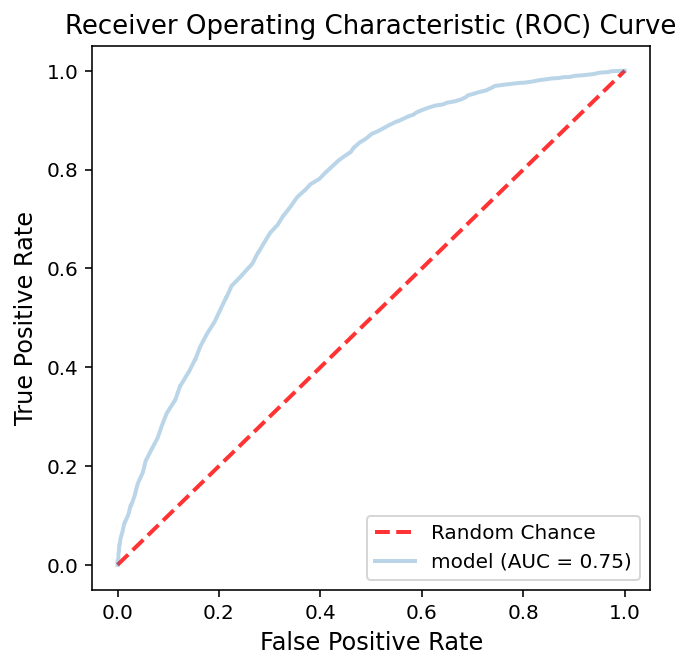

In [132]:
def plot_roc(model, X, y):
    figure = plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Random Chance', alpha=.8)
    metrics.plot_roc_curve(model, X, y, name='model', alpha=0.3, lw=2, ax=plt.gca())
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=13)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.show()

plot_roc(model, X_test, y_test)

In [133]:
# Bootstrap uncertainty analysis

# Metrics based on predictions
prediction_metrics = {'True Positive Rate (i.e. sensitivity, or recall)': metrics.recall_score,
                      'True Negative Rate (i.e. specificity)': lambda x, y: metrics.recall_score(x, y, pos_label=0),
                      'Balanced Accuracy': metrics.balanced_accuracy_score,
                      'Positive Predictive Value (precision)': metrics.precision_score}

# Metrics based on probabilities
probability_metrics = {'Area Under ROC': metrics.roc_auc_score}

for name, metric_func in prediction_metrics.items():
    print(name, ":", utils.format_uncertainty(*utils.bootstrap_conf_int(y_test, test_preds, metric_func, k=25)))

for name, metric_func in probability_metrics.items():
    print(name, ":", utils.format_uncertainty(*utils.bootstrap_conf_int(y_test, test_probs, metric_func, k=25)))



True Positive Rate (i.e. sensitivity, or recall) : 0.86183 +/- 0.00921
True Negative Rate (i.e. specificity) : 0.50827 +/- 0.02680
Balanced Accuracy : 0.68576 +/- 0.01156
Positive Predictive Value (precision) : 0.86035 +/- 0.00840
Area Under ROC : 0.75230 +/- 0.01055


In [134]:
# test_probs

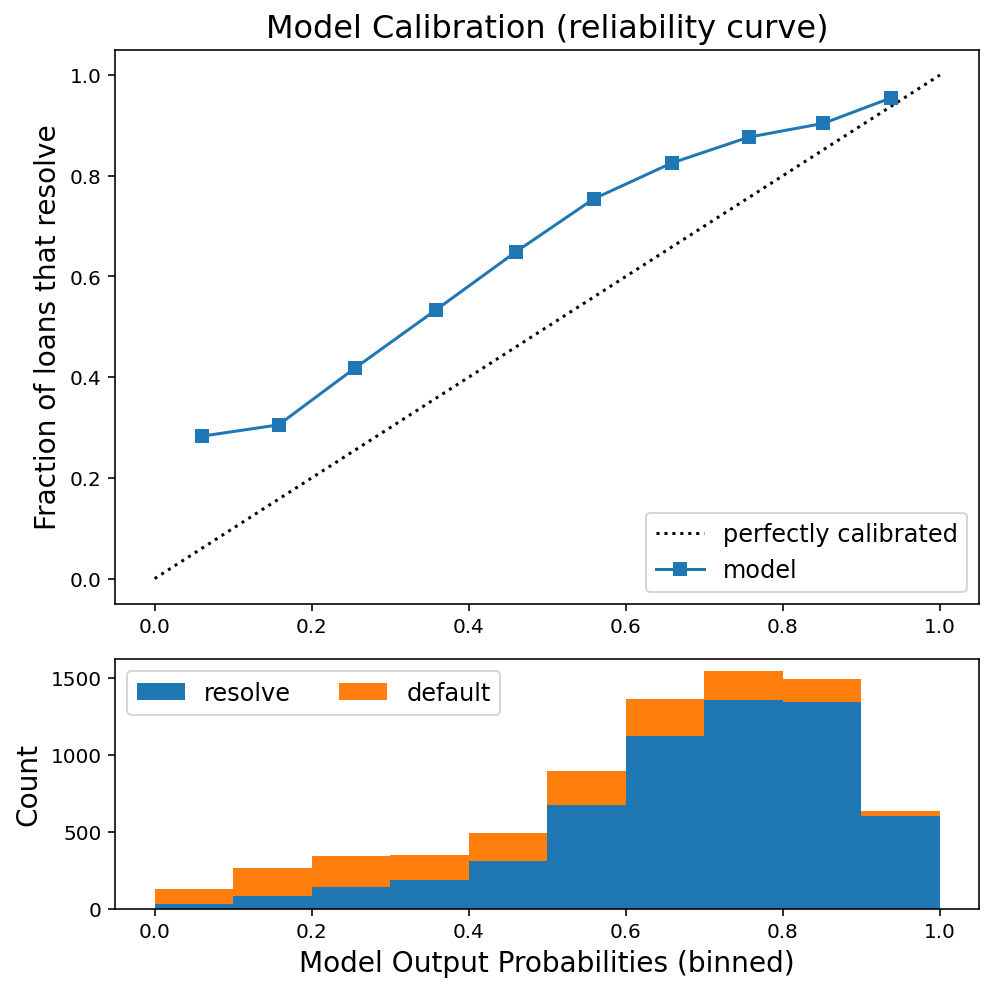

In [135]:
# Calibration curve
def plot_calibration(bin_true_prob, bin_pred_prob):
    plt.figure(figsize=(7, 7))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="perfectly calibrated")
    ax1.plot(bin_pred_prob, bin_true_prob, "s-",
             label="model")

    ax2.hist([test_probs[y_test == 1], test_probs[y_test == 0]], label=["resolve", "default"],
              histtype='bar', stacked=True)

    ax1.set_ylabel("Fraction of loans that resolve", fontsize=14)
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right", fontsize=12)
    ax1.set_title('Model Calibration (reliability curve)', fontsize=16)

    ax2.set_xlabel("Model Output Probabilities (binned)", fontsize=14)
    ax2.set_ylabel("Count", fontsize=14)
    ax2.legend(loc="upper left", ncol=2, fontsize=12)

    plt.tight_layout()
    plt.show()

bin_true_prob, bin_pred_prob = calibration_curve(y_test, test_probs, n_bins=10)
plot_calibration(bin_true_prob, bin_pred_prob)

## Fairness
Here we compute some fairness metrics with respect to gender.

In [136]:
# Create a gender identifying mask
gender_mask = (X_test["SEX"] == 1)  # True: Male, False: Female 
print('Percent Male:', round(np.mean(gender_mask), 5), 'Percent Female:', round(np.mean(~gender_mask), 5))

Percent Male: 0.40267 Percent Female: 0.59733


In [137]:
# Run the analysis
gender_analysis = utils.FairnessAnalysis(y_test, test_probs, gender_mask)
gender_metrics = gender_analysis.compute(best_th)
for attr, name in utils.FairnessAnalysis.metric_names.items():
    print(name, ":", round(getattr(gender_metrics, attr), 5))

Equal Opportunity : -0.01676
False Positive Rate Balance : 0.00329
Average Odds : -0.00673
Demographic Parity : -0.03082
Positive Predictive Parity : -0.03874
Balanced Accuracy : 0.68539


In [138]:
# Bootstrap Uncertainty
bs_metrics = []
np.random.seed(0)
for i in range(25):
    idx = np.random.choice(len(y_test), len(y_test), replace=True)
    bs_metrics.append(utils.FairnessAnalysis(y_test[idx], test_probs[idx], gender_mask[idx]).compute(best_th))

bs_metrics = np.array(bs_metrics)

In [139]:
for i, attr in enumerate(gender_metrics._fields):
    print(utils.FairnessAnalysis.metric_names[attr], ":", utils.format_uncertainty(bs_metrics[:, i].mean(), 2 * bs_metrics[:, i].std()))

Equal Opportunity : -0.01706 +/- 0.02270
False Positive Rate Balance : 0.00811 +/- 0.04930
Average Odds : -0.00447 +/- 0.02565
Demographic Parity : -0.02992 +/- 0.02167
Positive Predictive Parity : -0.04023 +/- 0.01976
Balanced Accuracy : 0.68526 +/- 0.01055


## Performance-Fairness Tradeoffs
Here we explore fairness-performance tradeoffs stemming from our choice of lending threshold.

In [140]:
# Split Threshold Sweep
th_a = np.linspace(0.3, 0.7, 500)
th_b = np.linspace(0.3, 0.7, 500)
grid_th_a, grid_th_b = np.meshgrid(th_a, th_b, sparse=True)
gender_metrics_split_sweep = gender_analysis.compute(grid_th_a, grid_th_b)

In [141]:
# Find best split threshold
bal_acc_grid = gender_metrics_split_sweep.bal_acc
idx = np.unravel_index(bal_acc_grid.argmax(), bal_acc_grid.shape)
best_th_a, best_th_b = th_a[idx[1]], th_b[idx[0]]
print(f"Best Balanced Accuracy (split): {bal_acc_grid.max():.5f} with Male TH: {best_th_a:.3f}, Female TH: {best_th_b:.3f}")

Best Balanced Accuracy (split): 0.69659 with Male TH: 0.620, Female TH: 0.609


In [142]:
# Find bal accuracy when fairness constrained
constrained_bal_acc = np.copy(bal_acc_grid)
constrained_bal_acc[np.where(gender_metrics_split_sweep.equal_opp <= -0.000)] = 0
idx = np.unravel_index(constrained_bal_acc.argmax(), constrained_bal_acc.shape)
best_con_th_a, best_con_th_b = th_a[idx[1]], th_b[idx[0]]
print(f"Best Fairness-Constrained Balanced Accuracy: {constrained_bal_acc.max():.5f} with Male TH: {best_con_th_a:.3f}, Female TH: {best_con_th_b:.3f}")

Best Fairness-Constrained Balanced Accuracy: 0.69412 with Male TH: 0.600, Female TH: 0.621


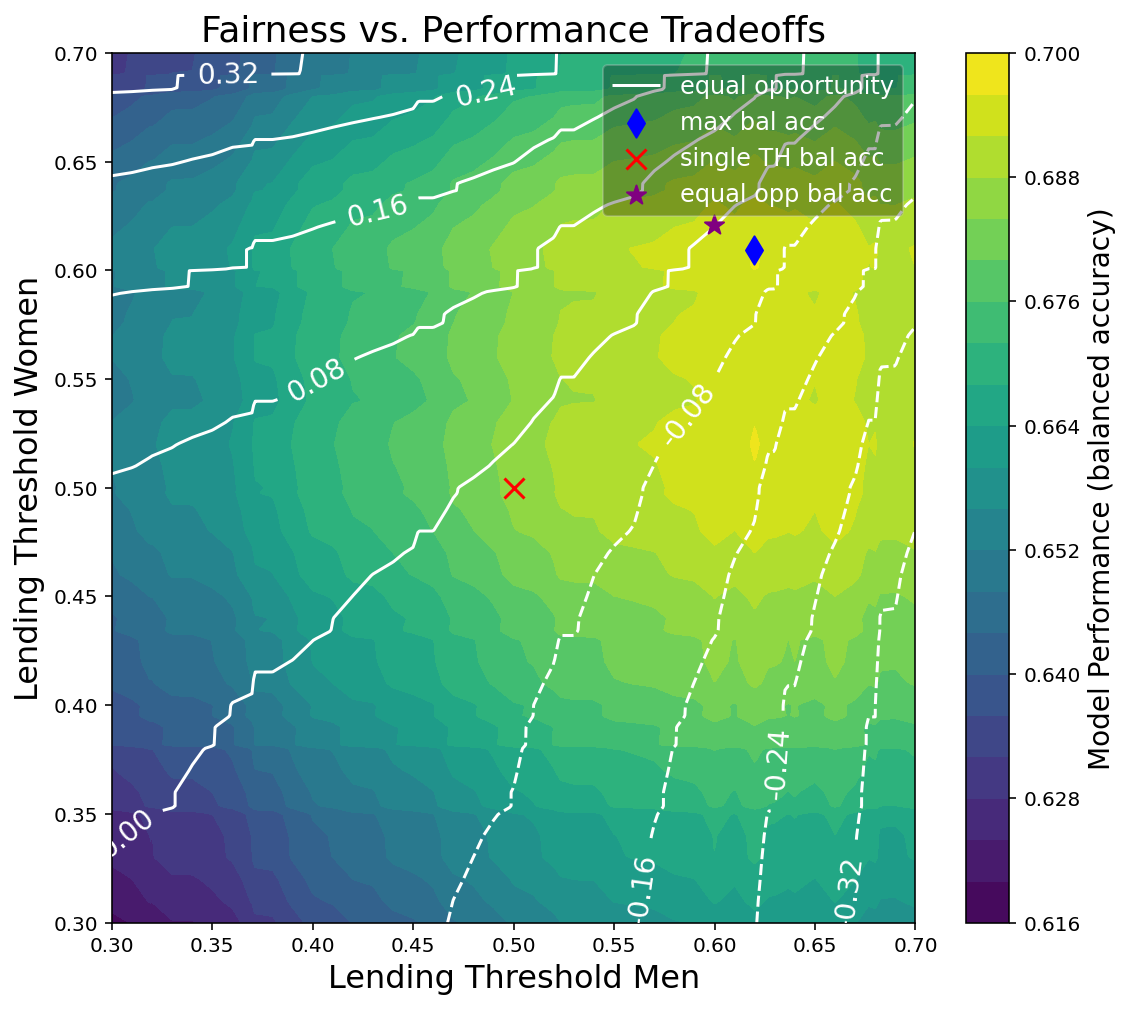

In [143]:
# Plot
plt.figure(figsize=(9,8))
plt.title('Fairness vs. Performance Tradeoffs', fontsize=18)
plt.xlabel('Lending Threshold Men', fontsize=16)
plt.ylabel('Lending Threshold Women', fontsize=16)
plt.xlim(np.min(th_a), np.max(th_a))
plt.ylim(np.min(th_b), np.max(th_b))

bal_acc_lns = plt.contourf(th_a, th_b, gender_metrics_split_sweep.bal_acc, levels=20)

eo_lns = plt.contour(th_a, th_b, gender_metrics_split_sweep.equal_opp, colors='white', levels=10)
eo_lns.collections[-1].set_label('equal opportunity')

cbar = plt.colorbar(bal_acc_lns)
cbar.set_label('Model Performance (balanced accuracy)', fontsize=14)
plt.clabel(eo_lns, inline=1,fmt='%1.2f', fontsize=14)

# Mark maximums
# plt.plot([0, 1], [0, 1], c='gray', ls=':', label='single threshold')
plt.scatter(best_th_a, best_th_b, c='b', marker='d', s=100, label= 'max bal acc', zorder=2)
plt.scatter(best_th, best_th, c='r', marker='x', s=100, label= 'single TH bal acc', zorder=2)
plt.scatter(best_con_th_a, best_con_th_b, c='purple', marker='*', s=100, label= 'equal opp bal acc', zorder=2)
lgnd = plt.legend(framealpha=0.3, facecolor='black', fontsize=12, loc='upper right')
for text in lgnd.get_texts():
    text.set_color("white")
plt.show()

#### Fairness-Performance Tradeoffs (split threshold)
Once the analysis has been run, we can visualize the fairness-performance tradeoffs of operating the model at various lending risk threshold settings. Operating the model at a higher lending risk threshold equates to a lower loan approval rate. The x-axis shows a range of possible lending risk thresholds for men, 
while the y-axis shows a range of possible lending risk thresholds for women. 

The heatmap indicates the model's expected performance (balanced accuracy) when operated at each pair of risk thresholds. Balanced accuracy is the average of the true positive rate (TPR), (i.e. sensitivity, or recall), and the true negative rate (TNR) (i.e. specificity). In our AIDA credit approval system, we use (a possibly weighted) balanced accuracy as a stand-in for the expected gross profit (this is further explored in the report).

The white contour lines indicate the equal opportunity group fairness metric with respect to gender. Equal opportunity measures the difference in the true positive rates between two groups of individuals, in this case men and women. It is computed as `TPR_men - TPR_women`, thus it is optimal when equal to zero (0). The true positive rate corresponds to the probability that an applicant who would hypothetically repay their loan is accepted by the model.

We plot three points of interest. 
The blue diamond maximizes the unconstrained model performance.
The red X maximizes model performance while keeping the *same* lending risk threshold for both men and women.
The purple star maximizes the model performance while ensuring optimal gender fairness as measured via equal opportunity.

## Personal Attributes
Here we consider how we might justify the inclusion of personal attributes

In [36]:
personal_attrs = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']

In [37]:
# Leave one out analysis
loo_metrics = []
for i, attr in enumerate(personal_attrs):
    print('\nTraining model without:', attr)
    model_loo = utils.train_log_reg_model(X_train.drop(columns=[attr]), y_train, seed=0, C=best_regularizer, verbose=False)
    
    # Predict and compute fairness Metrics
    loo_test_probs = prob_of_good(model_loo, X_test.drop(columns=[attr]))
    loo_analysis = utils.FairnessAnalysis(y_test, loo_test_probs, gender_mask)
    loo_metrics.append(loo_analysis.compute(best_th))
    
    # Display results as they arrive
    for field, name in utils.FairnessAnalysis.metric_names.items():
        print(name, ":", round(getattr(loo_metrics[i], field), 5))


Training model without: SEX
Equal Opportunity : -0.03221
False Positive Rate Balance : 0.00774
Average Odds : -0.01223
Demographic Parity : -0.04141
Positive Predictive Parity : -0.04228
Balanced Accuracy : 0.68271

Training model without: EDUCATION
Equal Opportunity : -0.0452
False Positive Rate Balance : -0.01531
Average Odds : -0.03026
Demographic Parity : -0.05681
Positive Predictive Parity : -0.03847
Balanced Accuracy : 0.68432

Training model without: MARRIAGE
Equal Opportunity : -0.05304
False Positive Rate Balance : -0.00349
Average Odds : -0.02826
Demographic Parity : -0.05981
Positive Predictive Parity : -0.043
Balanced Accuracy : 0.68117

Training model without: AGE
Equal Opportunity : -0.06084
False Positive Rate Balance : -0.02414
Average Odds : -0.04249
Demographic Parity : -0.07111
Positive Predictive Parity : -0.03792
Balanced Accuracy : 0.68702


In [38]:
# # Transform into percent differences
# bal_acc_deltas = [100 * (loo.bal_acc - gender_metrics.bal_acc) / gender_metrics.bal_acc for loo in loo_metrics]
# equal_opp_deltas = [100 * (loo.equal_opp - gender_metrics.equal_opp) / np.abs(gender_metrics.equal_opp) for loo in loo_metrics]

# Keep as absolutes
bal_acc_deltas = [loo.bal_acc - gender_metrics.bal_acc for loo in loo_metrics]
equal_opp_deltas = [loo.equal_opp - gender_metrics.equal_opp for loo in loo_metrics]

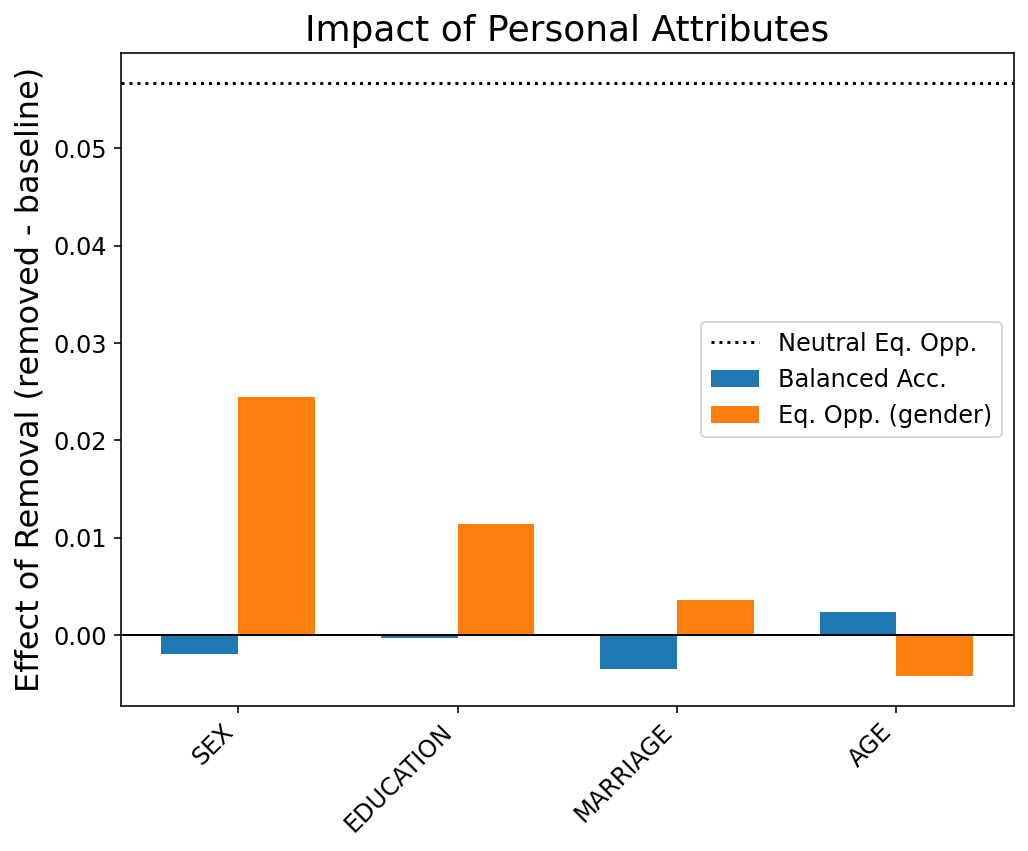

In [39]:
# Plot
plt.figure(figsize=(8,6))
plt.title('Impact of Personal Attributes', fontsize=18)
x = np.arange(len(personal_attrs))  # the label locations
width = 0.35  # the width of the bars
rects1 = plt.bar(x - width/2, bal_acc_deltas, width, label='Balanced Acc.')
rects2 = plt.bar(x + width/2, equal_opp_deltas, width, label='Eq. Opp. (gender)')
plt.axhline(0, c='k', ls='-', lw='1')
plt.axhline(-gender_metrics.equal_opp, c='k', ls=':', label='Neutral Eq. Opp.') # show neutrality
plt.xticks(x, personal_attrs, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Effect of Removal (removed - baseline)', fontsize=16)
plt.legend(fontsize=12)
plt.show()

#### Justifying the use of Personal Attributes
After running a "leave-one-out" feature removal analysis, we can assess the approximate impact of personal attributes on both fairness and model performance. We plot the impact of removing each personal attribute on the model's performance (balanced accuracy) and the equal opportunity group fairness metric with respect to gender. We want balanced accuracy to be as high a possible, while ideally equal opportunity would be at neutrality. 

**Tradeoffs to be further examined**: Attributes for which removal negatively affect model performance but positively affect the fairness metric(s) of interest (or vice-versa). In this example, SEX, EDUCATION, MARRIAGE, and AGE. 

**Evidence for inclusion**: Attributes for which removal negatively affect both model performance and the fairness metric(s) of interest. In this example, none. 

**Evidence for exclusion**: Attributes for which removal positively affect both model performance and the fairness metric(s) of interest. In this example, none.